In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
# %matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
import tensorflow as tf
import cv2

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
all_xray_df = pd.read_csv('./data/training_labels.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join( './data/training', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 4000 , Total Headers 4000


,Image Index,Finding Labels,path
3661,00010635_001.png,Effusion,./data/training/00010635_001.png
332,00010007_156.png,Effusion,./data/training/00010007_156.png
1923,00010563_009.png,No Finding,./data/training/00010563_009.png


In [5]:
#all_image_paths

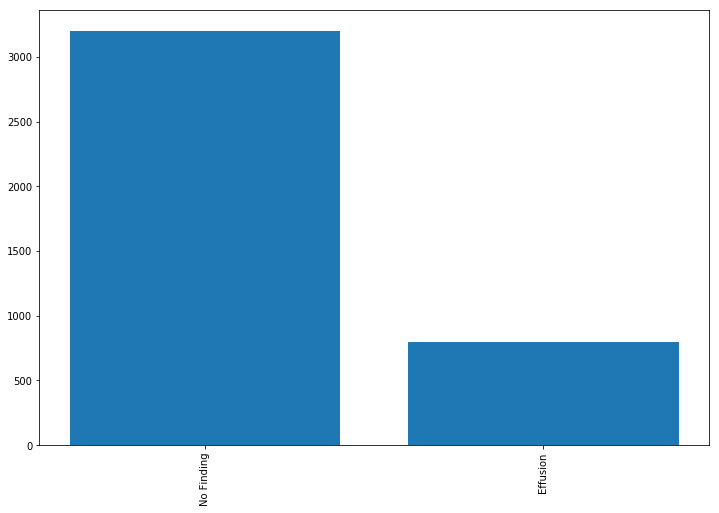

In [6]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:2]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [8]:
all_xray_df['Label'] = all_xray_df['Finding Labels'].map(lambda x: 0 if x=='No Finding' else 1.0)
#all_xray_df.sample(10)

In [9]:
all_xray_df['Label'].values

array([1., 1., 1., ..., 0., 0., 0.])

[3200.0, 800.0]


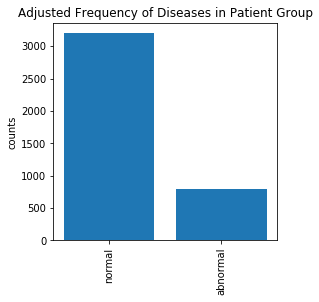

In [10]:
abnormal_count = np.sum(all_xray_df['Label'].values,0)
normal_count = all_xray_df.shape[0]-abnormal_count
label_counts = [normal_count, abnormal_count]
print(label_counts)
fig, ax1 = plt.subplots(1,1,figsize = (4, 4))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(['normal', 'abnormal'], rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('counts')

In [11]:
#all_xray_df

In [12]:
def load_data(train_df):
    train_filenames = train_df['path'].values
    train_labels = np.stack(train_df['Label'].map(lambda x: 0 if x==0 else 1))
    x_train = []
    for filename in train_filenames:
        img = cv2.imread(filename)
        x_train.append(img)
    return np.asarray(x_train), train_labels

In [ ]:
import tensorflow as tf

import numpy as np
from functools import reduce

VGG_MEAN = [103.939, 116.779, 123.68]


class Vgg19:
    """
    A trainable version VGG19.
    """

    def __init__(self, vgg19_npy_path=None, trainable=True, dropout=0.5):
        if vgg19_npy_path is not None:
            self.data_dict = np.load(vgg19_npy_path, encoding='latin1').item()
        else:
            self.data_dict = None

        self.var_dict = {}
        self.trainable = trainable
        self.dropout = dropout

    def build(self, rgb, train_mode=None):
        """
        load variable from npy to build the VGG

        :param rgb: rgb image [batch, height, width, 3] values scaled [0, 1]
        :param train_mode: a bool tensor, usually a placeholder: if True, dropout will be turned on
        """

        rgb_scaled = rgb * 255.0

        # Convert RGB to BGR
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=rgb_scaled)
        assert red.get_shape().as_list()[1:] == [224, 224, 1]
        assert green.get_shape().as_list()[1:] == [224, 224, 1]
        assert blue.get_shape().as_list()[1:] == [224, 224, 1]
        bgr = tf.concat(axis=3, values=[
            blue - VGG_MEAN[0],
            green - VGG_MEAN[1],
            red - VGG_MEAN[2],
        ])
        assert bgr.get_shape().as_list()[1:] == [224, 224, 3]

        self.conv1_1 = self.conv_layer(bgr, 3, 64, "conv1_1")
        self.conv1_2 = self.conv_layer(self.conv1_1, 64, 64, "conv1_2")
        self.pool1 = self.max_pool(self.conv1_2, 'pool1')

        self.conv2_1 = self.conv_layer(self.pool1, 64, 128, "conv2_1")
        self.conv2_2 = self.conv_layer(self.conv2_1, 128, 128, "conv2_2")
        self.pool2 = self.max_pool(self.conv2_2, 'pool2')

        self.conv3_1 = self.conv_layer(self.pool2, 128, 256, "conv3_1")
        self.conv3_2 = self.conv_layer(self.conv3_1, 256, 256, "conv3_2")
        self.conv3_3 = self.conv_layer(self.conv3_2, 256, 256, "conv3_3")
        self.conv3_4 = self.conv_layer(self.conv3_3, 256, 256, "conv3_4")
        self.pool3 = self.max_pool(self.conv3_4, 'pool3')

        self.conv4_1 = self.conv_layer(self.pool3, 256, 512, "conv4_1")
        self.conv4_2 = self.conv_layer(self.conv4_1, 512, 512, "conv4_2")
        self.conv4_3 = self.conv_layer(self.conv4_2, 512, 512, "conv4_3")
        self.conv4_4 = self.conv_layer(self.conv4_3, 512, 512, "conv4_4")
        self.pool4 = self.max_pool(self.conv4_4, 'pool4')

        self.conv5_1 = self.conv_layer(self.pool4, 512, 512, "conv5_1")
        self.conv5_2 = self.conv_layer(self.conv5_1, 512, 512, "conv5_2")
        self.conv5_3 = self.conv_layer(self.conv5_2, 512, 512, "conv5_3")
        self.conv5_4 = self.conv_layer(self.conv5_3, 512, 512, "conv5_4")
        self.pool5 = self.max_pool(self.conv5_4, 'pool5')

        self.fc6 = self.fc_layer(self.pool5, 25088, 4096, "fc6")  # 25088 = ((224 // (2 ** 5)) ** 2) * 512
        self.relu6 = tf.nn.relu(self.fc6)
        if train_mode is not None:
            self.relu6 = tf.cond(train_mode, lambda: tf.nn.dropout(self.relu6, self.dropout), lambda: self.relu6)
        elif self.trainable:
            self.relu6 = tf.nn.dropout(self.relu6, self.dropout)

        self.fc7 = self.fc_layer(self.relu6, 4096, 4096, "fc7")
        self.relu7 = tf.nn.relu(self.fc7)
        if train_mode is not None:
            self.relu7 = tf.cond(train_mode, lambda: tf.nn.dropout(self.relu7, self.dropout), lambda: self.relu7)
        elif self.trainable:
            self.relu7 = tf.nn.dropout(self.relu7, self.dropout)

        self.fc8 = self.fc_layer(self.relu7, 4096, 1000, "fc8")

        self.prob = tf.nn.softmax(self.fc8, name="prob")

        self.data_dict = None

    def avg_pool(self, bottom, name):
        return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def max_pool(self, bottom, name):
        return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

    def conv_layer(self, bottom, in_channels, out_channels, name):
        with tf.variable_scope(name):
            filt, conv_biases = self.get_conv_var(3, in_channels, out_channels, name)

            conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')
            bias = tf.nn.bias_add(conv, conv_biases)
            relu = tf.nn.relu(bias)

            return relu

    def fc_layer(self, bottom, in_size, out_size, name):
        with tf.variable_scope(name):
            weights, biases = self.get_fc_var(in_size, out_size, name)

            x = tf.reshape(bottom, [-1, in_size])
            fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

            return fc

    def get_conv_var(self, filter_size, in_channels, out_channels, name):
        initial_value = tf.truncated_normal([filter_size, filter_size, in_channels, out_channels], 0.0, 0.001)
        filters = self.get_var(initial_value, name, 0, name + "_filters")

        initial_value = tf.truncated_normal([out_channels], .0, .001)
        biases = self.get_var(initial_value, name, 1, name + "_biases")

        return filters, biases

    def get_fc_var(self, in_size, out_size, name):
        initial_value = tf.truncated_normal([in_size, out_size], 0.0, 0.001)
        weights = self.get_var(initial_value, name, 0, name + "_weights")

        initial_value = tf.truncated_normal([out_size], .0, .001)
        biases = self.get_var(initial_value, name, 1, name + "_biases")

        return weights, biases

    def get_var(self, initial_value, name, idx, var_name):
        if self.data_dict is not None and name in self.data_dict:
            value = self.data_dict[name][idx]
        else:
            value = initial_value

        if self.trainable:
            var = tf.Variable(value, name=var_name)
        else:
            var = tf.constant(value, dtype=tf.float32, name=var_name)

        self.var_dict[(name, idx)] = var

        # print var_name, var.get_shape().as_list()
        assert var.get_shape() == initial_value.get_shape()

        return var

    def save_npy(self, sess, npy_path="./vgg19-save.npy"):
        assert isinstance(sess, tf.Session)

        data_dict = {}

        for (name, idx), var in list(self.var_dict.items()):
            var_out = sess.run(var)
            if name not in data_dict:
                data_dict[name] = {}
            data_dict[name][idx] = var_out

        np.save(npy_path, data_dict)
        print(("file saved", npy_path))
        return npy_path

    def get_var_count(self):
        count = 0
        for v in list(self.var_dict.values()):
            count += reduce(lambda x, y: x * y, v.get_shape().as_list())
        return count